# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
from dataprep.datasets import load_dataset
from dataprep.eda import create_report
df = load_dataset("titanic")
create_report(df).show()

ModuleNotFoundError: No module named 'dataprep'

In [3]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [10]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [11]:
def grab_object(df):
    return df.select_dtypes(include=['object'])

In [12]:
# The FunctionTransformer will turn my function
# into a transformer.
GrabNumeric = FunctionTransformer(grab_numeric)
GrabObject = FunctionTransformer(grab_object)

In [12]:
holder = GrabObject.transform(X_train)
holder

,Sex,Ticket,Cabin,Embarked
298,male,19988,C106,S
884,male,SOTON/OQ 392076,NaN,S
247,female,250649,NaN,S
478,male,350060,NaN,S
305,male,113781,C22 C26,S
...,...,...,...,...
106,female,343120,NaN,S
270,male,113798,NaN,S
860,male,350026,NaN,S
435,female,113760,B96 B98,S


If you want to use both sets of transformations, you will need to use a Column Transformations

In [13]:
# Pipe!
pipe = Pipeline(steps=[
#     ('obj',GrabObject),
#     ('ohe',OneHotEncoder()),
    ('num',GrabNumeric),
    ('ss',StandardScaler()),
])
pipe.fit_transform(X_train)

array([[        nan, -0.0325683 ],
       [-0.30465857, -0.48733085],
       [-0.3735649 , -0.34285405],
       ...,
       [ 0.79784282, -0.35045024],
       [-1.06262827,  1.7030926 ],
       [-0.58028391,  0.8747751 ]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [14]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical
subpipe_num = Pipeline(steps=[('get_num', GrabNumeric),
                              ('num_impute', SimpleImputer()),
                              ('ss', StandardScaler())])

subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

subpipe_ord = Pipeline(steps=[('ord_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OrdinalEncoder())])

In [15]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
ct = ColumnTransformer(transformers=[
    ('subpipe_num',subpipe_num,X_train.columns),
    ('subpipe_cat',subpipe_cat,[0,5,7,8]),
    ('subpipe_ord',subpipe_ord,[1]),
])

In [68]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[
    ('ct',ct),
    ('logreg',LogisticRegression(random_state=42))
])

In [69]:
logreg_model_pipe.fit(X_train,y_train)
logreg_model_pipe.score(X_train,y_train)

0.8997005988023952

In [71]:
logreg_model_pipe.score(X_test,y_test)

0.820627802690583

In [72]:
cross_val_score(logreg_model_pipe,X_train,y_train)

array([0.79104478, 0.85074627, 0.79104478, 0.7593985 , 0.86466165])

## Bringing in Our Modeling Class from before

In [5]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [80]:
# Use the class with logreg pipe
log_pipe = ModelWithCV(logreg_model_pipe, model_name = 'log_pipe',X=X_train,y=y_train)

<AxesSubplot:title={'center':'CV Results for `log_pipe` Model'}>

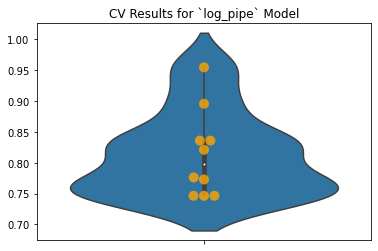

In [81]:
fig,ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [16]:
# rfc!
rfc = RandomForestClassifier(random_state=42)
rfc_model_pipe = Pipeline([
    ('ct',ct),
    ('rfc',rfc)
])

In [17]:
rfc_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x0000026D59EF1F70>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [18]:
rfc_pipe = ModelWithCV(model=rfc_model_pipe, 
                       model_name = 'rfc_pipe',
                       X=X_train,
                       y=y_train)

<AxesSubplot:title={'center':'CV Results for `rfc_pipe` Model'}>

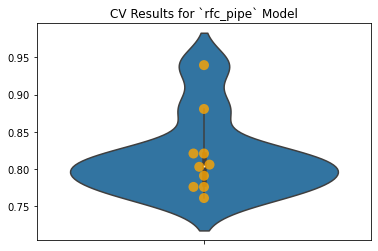

In [107]:
fig,ax = plt.subplots()
rfc_pipe.plot_cv(ax=ax)

In [19]:
y_train

298    1
884    0
247    1
478    0
305    1
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 668, dtype: int64

### Gradient Booster

In [84]:
# gbc!
gbc_model_pipe = Pipeline([
    ('ct',ct),
    ('gbc',GradientBoostingClassifier(random_state=42))
])

In [92]:
gbc_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [93]:
gbc_pipe = ModelWithCV(model=gbc_model_pipe, 
                       model_name = 'gbc_pipe',
                       X=X_train,
                       y=y_train)

<AxesSubplot:title={'center':'CV Results for `gbc_pipe` Model'}>

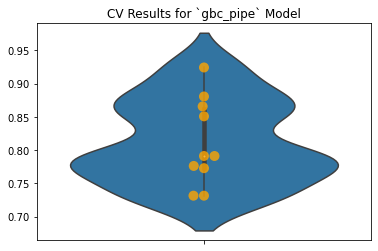

In [94]:
fig,ax = plt.subplots()
gbc_pipe.plot_cv(ax=ax)

## Tuning and Cross-Validating

In [95]:
# GridSearch?
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__min_samples_leaf'] = [1,5,10]

In [96]:
params

{'rfc__criterion': ['gini', 'entropy'], 'rfc__min_samples_leaf': [1, 5, 10]}

In [97]:
gs = GridSearchCV(estimator=rfc_model_pipe,param_grid=params,cv=10)

In [98]:
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embar

In [101]:
pd.DataFrame(gs.cv_results_).mean_test_score

0    0.817526
1    0.621257
2    0.621257
3    0.814518
4    0.621257
5    0.621257
Name: mean_test_score, dtype: float64

In [102]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                  

In [103]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1}

In [108]:
# Mean test score for each of six models
pd.DataFrame(gs.cv_results_).mean_test_score.mean()

0.6861789537162671

In [152]:
stc = StackingClassifier(estimators = [
    ('log_reg',LogisticRegression(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
    ('gbc',GradientBoostingClassifier(random_state=42))
])

In [153]:
stc_model_pipe = Pipeline([('ct',ct),('stc',stc)])

In [154]:
stc_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=...
                                                              

In [155]:
stc_model_pipe.score(X_test,y_test)

0.8161434977578476

In [156]:
params = {
    'ct__subpipe_num__num_impute__strategy':['mean','median'],
    'stc__rfc__criterion':['gini','entropy'],
    'stc__log_reg__max_iter':[50,100],
}

In [157]:
super_gs = GridSearchCV(stc_model_pipe,
                       param_grid=params,
                       cv=2)

In [158]:
super_gs.fit(X_train,y_train)

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embark

In [159]:
super_gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'mean',
 'stc__log_reg__max_iter': 50,
 'stc__rfc__criterion': 'gini'}

In [160]:
super_gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=...
                                                              

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [133]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [134]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [135]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [136]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [137]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [138]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [139]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [140]:
# imbpipe!
imb_pipe = ImPipeline(steps=[('ct',ct),
                            ('sm',SMOTE(random_state=42)),
                            ('rfc',RandomForestClassifier(random_state=42))])

In [142]:
imb_pipe.fit(X_train,y_train);

In [143]:
imb_pipe.score(X_train,y_train)

0.9985029940119761

In [144]:
imb_pipe.score(X_test,y_test)

0.8251121076233184

### Gridsearching

In [146]:
# Seriously? Again?
params = {
    'rfc__criterion':['gini','entropy'],
    'rfc__min_samples_leaf':[1,5,10],
    'sm__k_neighbors':[3,5,9]
}
gs = GridSearchCV(cv=10,param_grid=params,estimator=imb_pipe)
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x000001E431E77A60>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embar

In [149]:
finalmodel = gs.best_estimator_


C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


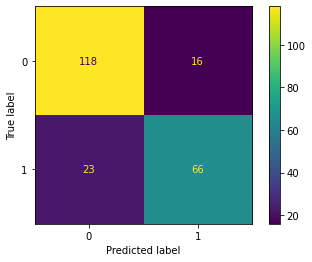

In [151]:
plot_confusion_matrix(finalmodel,X_test,y_test)

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [ ]:
final_model = imb_pipe

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat = final_model.predict(X_test)

In [ ]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")

## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






